# Training a Quantum Model on a Real Dataset

This tutorial will demonstrate how to train a quantum machine learning model to tackle a classification problem. Previous tutorials have featured small, artificial datasets. Here we will increase the problem complexity by considering a real-life classical dataset. We decided to pick a very well-known – albeit still relatively small – problem: the Iris flower dataset. This dataset even has its own Wikipedia [page](https://en.wikipedia.org/wiki/Iris_flower_data_set). Although the Iris dataset is well known to data scientists, we will briefly introduce it to refresh our memories. For comparison, we'll first train a classical counterpart to the quantum model.

So, let's get started:

- First, we'll load the dataset and explore what it looks like.
- Next, we'll train a classical model using [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from [scikit-learn](https://scikit-learn.org/) to see how well the classification problem can be solved using classical methods.
- After that, we'll introduce the Variational Quantum Classifier (VQC).
- To conclude, we'll compare the results obtained from both models.

## 1. Exploratory Data Analysis

First, let us explore the Iris dataset this tutorial will use and see what it contains. For our convenience, this [dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset) is available in scikit-learn and can be loaded easily.

In [1]:
from sklearn.datasets import load_iris

iris_data = load_iris()

If no parameters are specified in the `load_iris` function, then a dictionary-like object is returned by scikit-learn. Let's print the description of the dataset and see what is inside.

In [2]:
features = iris_data.data
labels = iris_data.target

Firstly, we'll normalize the features. Namely, we will apply a simple transformation to represent all features on the same scale. In our case, we squeeze all features onto the interval $[0, 1]$. Normalization is a common technique in machine learning and often leads to better numerical stability and convergence of an algorithm.

We can use `MinMaxScaler` from scikit-learn to perform this. Without specifying parameters, this does exactly what is required: maps data onto $[0, 1]$.

In [3]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

Before we train a model, we should split the dataset into two parts: a training dataset and a test dataset. We'll use the former to train the model and the latter to verify how well our models perform on unseen data.

As usual, we'll ask scikit-learn to do the boring job for us. We'll also fix the seed to ensure the results are reproducible.

In [4]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

As can be seen from the scores, the classical SVC algorithm performs very well. Next up, it's time to look at quantum machine learning models.

## 3. Training a Quantum Machine Learning Model

As an example of a quantum model, we'll train a variational quantum classifier (VQC). The VQC is the simplest classifier available in Qiskit Machine Learning and is a good starting point for newcomers to quantum machine learning who have a background in classical machine learning.

But before we train a model, let's examine what comprises the `VQC` class. Two of its central elements are the feature map and ansatz. What these are will now be explained.

Our data is classical, meaning it consists of a set of bits, not qubits. We need a way to encode the data as qubits. This process is crucial if we want to obtain an effective quantum model. We usually refer to this mapping as data encoding, data embedding, or data loading and this is the role of the feature map. While feature mapping is a common ML mechanism, this process of loading data into quantum states does not appear in classical machine learning as that only operates in the classical world.

Once the data is loaded, we must immediately apply a parameterized quantum circuit. This circuit is a direct analog to the layers in classical neural networks. It has a set of tunable parameters or weights. The weights are optimized such that they minimize an objective function. This objective function characterizes the distance between the predictions and known labeled data. A parameterized quantum circuit is also called a parameterized trial state, variational form, or ansatz. Perhaps, the latter is the most widely used term.

For more information, we direct the reader to the [Quantum Machine Learning Course](https://learn.qiskit.org/course/machine-learning).

Our choice of feature map will be the ``ZZFeatureMap``. The ``ZZFeatureMap`` is one of the standard feature maps in the Qiskit circuit library. We pass `num_features` as `feature_dimension`, meaning the feature map will have `num_features` or `4` qubits.

We decompose the feature map into its constituent gates to give the reader a flavor of how feature maps may look.

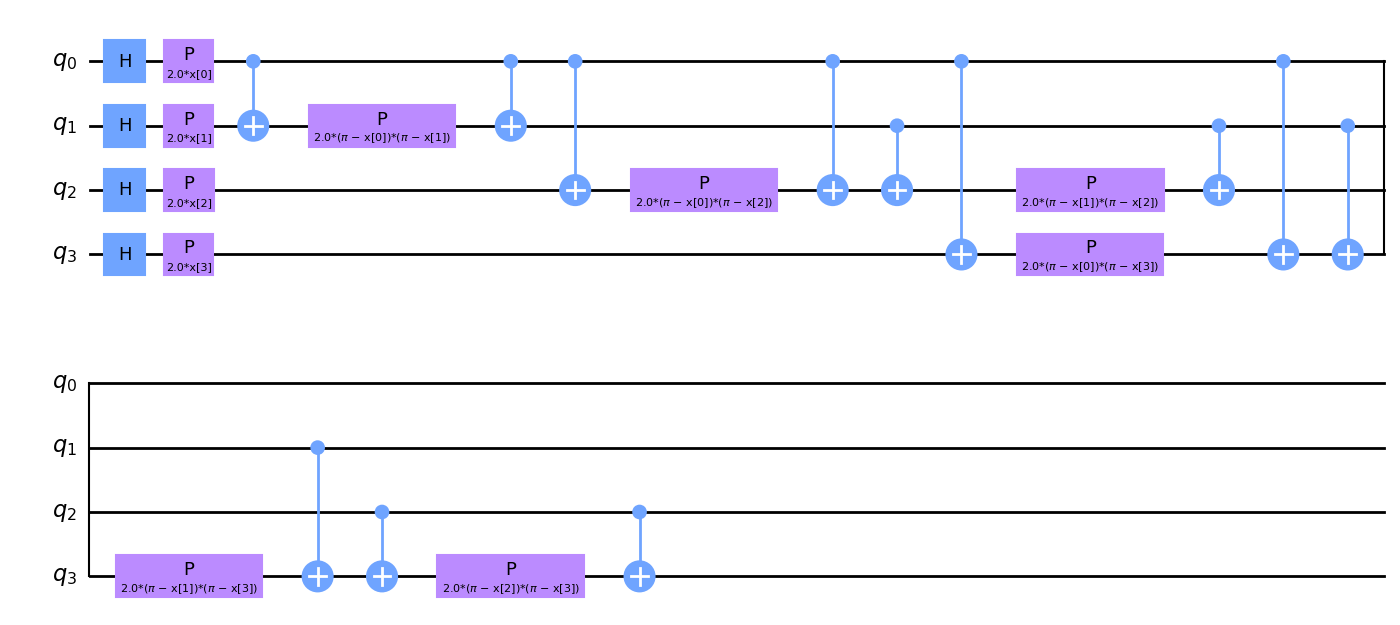

In [5]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

If you look closely at the feature map diagram, you will notice parameters `x[0], ..., x[3]`. These are placeholders for our features.

Now we create and plot our ansatz. Pay attention to the repetitive structure of the ansatz circuit. We define the number of these repetitions using the `reps` parameter.

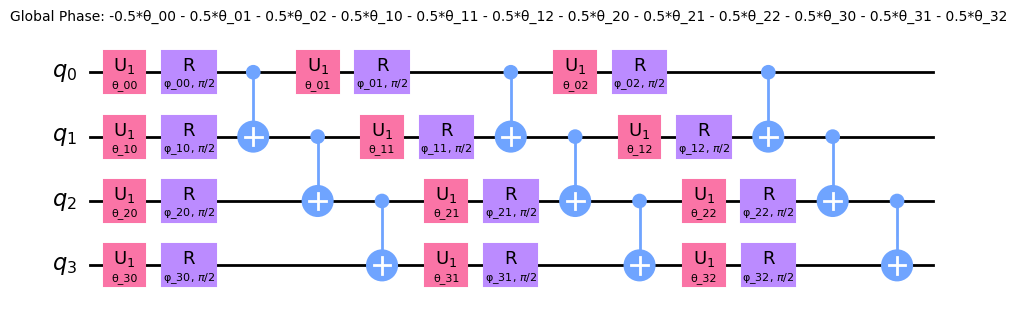

In [6]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

def real_amplitudes_circuit(num_qubits, depth):
    # Create a quantum register with the specified number of qubits
    qreg = QuantumRegister(num_qubits, name='q')

    # Create a circuit with the given quantum register
    circuit = QuantumCircuit(qreg)

    # Add a layer of single-qubit rotations and entangling gates for each depth
    for d in range(depth):
        # Add a layer of single-qubit rotations with random parameters
        for i in range(num_qubits):
            circuit.rz(Parameter('θ_{}{}'.format(i, d)), qreg[i])
            circuit.ry(Parameter('φ_{}{}'.format(i, d)), qreg[i])

        # Add a layer of entangling gates between adjacent qubits
        for i in range(num_qubits - 1):
            circuit.cx(qreg[i], qreg[i+1])

    # Return the circuit
    return circuit

ansatz = real_amplitudes_circuit(num_qubits=num_features, depth=3)
ansatz.decompose().draw(output="mpl", fold=20)

This circuit has 16 parameters named `θ[0], ..., θ[15]`. These are the trainable weights of the classifier.

We then choose an optimization algorithm to use in the training process. This step is similar to what you may find in classical deep learning frameworks. To make the training process faster, we choose a gradient-free optimizer. You may explore other optimizers available in Qiskit.

In [7]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In the next step, we define where to train our classifier. We can train on a simulator or a real quantum computer. Here, we will use a simulator. We create an instance of the `Sampler` primitive. This is the reference implementation that is statevector based. Using qiskit runtime services you can create a sampler that is backed by a quantum computer.

In [8]:
from qiskit.primitives import Sampler
from qiskit import IBMQ
from qiskit_ibm_runtime import Options, Sampler

# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-asu')

# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
options = Options(optimization_level=1)


sampler = Sampler(session=backend, options=options)

/tmp/ipykernel_13136/959645741.py:6: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
/tmp/ipykernel_13136/959645741.py:6: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


ApiException: Error: Provided API key could not be found., Code: 400

We will add a callback function called `callback_graph`. `VQC` will call this function for each evaluation of the objective function with two parameters: the current weights and the value of the objective function at those weights. Our callback will append the value of the objective function to an array so we can plot the iteration versus the objective function value. The callback will update the plot at each iteration. Note that you can do whatever you want inside a callback function, so long as it has the two-parameter signature we mentioned above.

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Now we are ready to construct the classifier and fit it. 

`VQC` stands for "variational quantum classifier." It takes a feature map and an ansatz and constructs a quantum neural network automatically. In the simplest case it is enough to pass the number of qubits and a quantum instance to construct a valid classifier. You may omit the `sampler` parameter, in this case a `Sampler` instance will be created for you in the way we created it earlier. We created it manually for illustrative purposes only.

Training may take some time. Please, be patient.

In [ ]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Let's see how the quantum model performs on the real-life dataset.

In [ ]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright